## Seminar 2: ALS

In [1]:
import os
from tqdm import tqdm
from typing import Tuple, List
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k

### 1. Download dataset

The data used in this seminar can be donwloaded from

https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data

We will use Netflix Prize Dataset, which consists movies and user ratings.

In [2]:
if not os.path.isfile('netflix_data.csv'):
    data = open('netflix_data.csv', mode='w')
    
    row = list()
    files=['archive/combined_data_1.txt',
           'archive/combined_data_2.txt', 
           'archive/combined_data_3.txt', 
           'archive/combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:]
                line = line.strip()
                if line.endswith(':'):
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()

In [3]:
print("Creating the dataframe from netflix_data.csv file..")
ratings = pd.read_csv(
    'netflix_data.csv', 
    sep=',', 
    names=['movie_id', 'user','rating','date']
)
ratings.date = pd.to_datetime(ratings.date)
print('Done.\n')

# # we are arranging the ratings according to time.
# print('Sorting the dataframe by date..')
# df_.sort_values(by='date', inplace=True)
# print('Done..')

Creating the dataframe from netflix_data.csv file..
Done.



In [4]:
ratings = ratings.sample(100_000)

In [5]:
ratings.head()

,movie_id,user,rating,date
12061478,2342,2529547,4,2005-01-10
58094814,10625,830739,4,2005-12-27
24317539,4570,1428883,3,2005-02-28
54150088,9863,194511,3,2005-06-25
83466039,14909,654455,3,2005-03-11


In [6]:
def ids_encoder(ratings):
    users = sorted(ratings['user'].unique())
    items = sorted(ratings['movie_id'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    # encode userids and itemids
    ratings.user = uencoder.transform(ratings.user.tolist())
    ratings.movie_id = iencoder.transform(ratings.movie_id.tolist())

    return ratings, uencoder, iencoder

ratings_, uencoder, iencoder = ids_encoder(ratings)

### 2. EDA

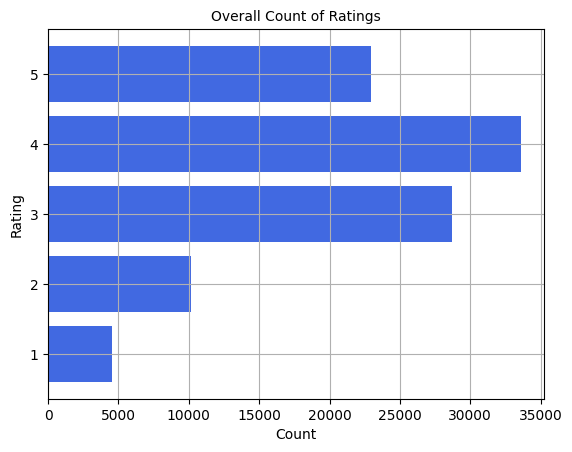

In [7]:
ratings_cnt = ratings.groupby('rating')['user'].count().rename('cnt_users').reset_index()
plt.barh(ratings_cnt.rating, ratings_cnt.cnt_users, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=10)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Rating', fontsize=10)
plt.grid()
plt.show()

In [8]:
ratings_per_movie = ratings.groupby(by='movie_id')['rating'].count().sort_values(ascending=False)
print(ratings_per_movie.describe().apply('{0:.2f}'.format))

count    9214.00
mean       10.85
std        22.28
min         1.00
25%         1.00
50%         3.00
75%         9.00
max       224.00
Name: rating, dtype: object


In [9]:
avg_ratings_per_movie = ratings.groupby(by='movie_id')['rating'].mean().sort_values(ascending=False)
print(avg_ratings_per_movie.describe().apply('{0:.2f}'.format))

count    9214.00
mean        3.41
std         0.91
min         1.00
25%         3.00
50%         3.50
75%         4.00
max         5.00
Name: rating, dtype: object


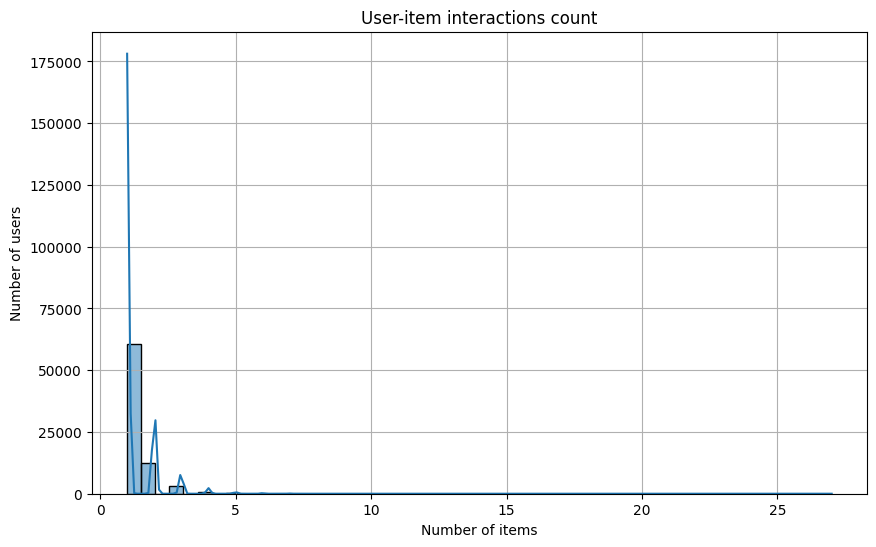

In [10]:
user_item_counts = ratings.groupby('user')['movie_id'].count().values

# Plot the histogram
plt.figure(figsize=(10, 6))
ax = sns.histplot(user_item_counts, bins=50, kde=True);
ax.set(xlabel="Number of items", ylabel="Number of users", title='User-item interactions count')
ax.grid()

### 3. ALS from scratch

Firstly, we prepare data and convert train matrix to `scipy` sparse matrix.

In [11]:
def split_data(ratings: pd.DataFrame) -> Tuple[sp._csr.csr_matrix, List[Tuple[float, float, float]]]:
    """Splitting dataset into train and test

    Args:
        ratings (pd.DataFrame): The ratings data

    Returns:
        Tuple[sp._csr.csr_matrix, List[Tuple[float, float, float]]]: The train and test datasets
    """
    user_item_matrix = ratings.pivot(index='user', columns='movie_id', values='rating').fillna(0)

    # Convert to sparse matrix
    ratings_csr = csr_matrix(user_item_matrix.values)

    # Select 20% of users randomly
    np.random.seed(42)
    unique_users = ratings['user'].unique()
    test_users = np.random.choice(unique_users, size=int(0.2 * len(unique_users)), replace=False)

    # Prepare train and test data
    train_data = ratings_csr.copy().toarray()
    test_data = []

    for user in test_users:
        user_index = np.where(unique_users == user)[0][0]
        user_ratings = np.where(train_data[user_index] > 0)[0]
        if len(user_ratings) > 0:
            test_item = np.random.choice(user_ratings)
            test_data.append((user_index, test_item, train_data[user_index, test_item]))
            train_data[user_index, test_item] = 0  # Remove one rating
    
    train_data = csr_matrix(train_data)

    return train_data, test_data

In [12]:
train_data, test_data = split_data(ratings)

Formula for ALS:
$$\arg\min_{x_i}\sum_{i,j}(A_{ij}-x_i^Ty_j)^2 + \lambda\sum_i|x_i|^2+ \lambda\sum_i|y_i|^2 = \bigg(\sum_{j}y_iy_i^T+\lambda I \bigg)^{-1}\bigg (\sum_j A_{ij}y_j \bigg )$$

In [13]:
class ALS:
    """
    A class to provide item2item recommendations for user.
    Attributes:
        train_data (sp._csr.csr_matrix): The training dataset
        test_data (pd.Dataframe): The test dataset
    """

    def __init__(self, train_data, test_data):
        self.train_data = train_data

    def calc_opposite_vectors(self, Y: np.ndarray, A: np.ndarray, k: int, lam: int) -> np.ndarray:
        """
        Method to calculate opposite vectors

        Args:
            Y (np.ndarray): The matrix of embeddings for the opposite factor 
            (e.g., item embeddings if solving for user embeddings)
            A (np.ndarray): The ratings matrix, where rows correspond to users (or items)
            and columns correspond to items (or users)
            k (int): Dimension of output embeddings
            lam (np.ndarray): Regularization coefficient

        Returns:
            np.ndarray: The updated matrix of embeddings for users (or items)
        """
        B = Y.T.dot(Y) + lam * np.eye(k)
        C = A.dot(Y)
        out = np.linalg.inv(B).dot(C.T).T
        return out

    def train(self, k: int, lam: float, iterations: int = 15) -> Tuple[np.ndarray, np.ndarray, List[float]]:
        '''Alternating Least Squares algorithm

        Args:
            ratings: sparse matrix of ratings
            k: size of embeddings
            lam: regularization term
            iterations: number of iterations

        Returns:
            Tuple[np.ndarray, np.ndarray, List[float]]: user embeddings, item embeddings and loss values
        '''
        num_users, num_items = self.train_data.shape
        X = np.random.randn(num_users, k)
        Y = np.random.randn(num_items, k)

        loss_values = []

        start = time.time()
        for i in range(iterations):
            X = self.calc_opposite_vectors(Y, self.train_data.toarray(), k, lam)

            Y = self.calc_opposite_vectors(X, self.train_data.toarray().T, k, lam)

            predictions = X.dot(Y.T)
            mse = np.mean((self.train_data.toarray() - predictions) ** 2)
            loss_values.append(mse)

            print(f"Iteration {i+1}/{iterations}, MSE: {mse}")
        
        end = time.time()
        print(f"Self-implemented ALS training took {end - start} sec")
        
        return X, Y, loss_values

In [14]:
als = ALS(train_data, test_data)

In [15]:
k = 10
lam = 0.1
iterations = 15

user_embeddings, item_embeddings, loss_values = als.train(k, lam, iterations)

Iteration 1/15, MSE: 0.0016712199678235997
Iteration 2/15, MSE: 0.0016505871512596303
Iteration 3/15, MSE: 0.0016455441613858796
Iteration 4/15, MSE: 0.0016426154768287512
Iteration 5/15, MSE: 0.001640725133660669
Iteration 6/15, MSE: 0.001639474243052288
Iteration 7/15, MSE: 0.0016386250025037415
Iteration 8/15, MSE: 0.0016380296923398086
Iteration 9/15, MSE: 0.0016376014961656015
Iteration 10/15, MSE: 0.0016372892584976702
Iteration 11/15, MSE: 0.001637060702712408
Iteration 12/15, MSE: 0.0016368935120406383
Iteration 13/15, MSE: 0.0016367712346538124
Iteration 14/15, MSE: 0.0016366815074332476
Iteration 15/15, MSE: 0.0016366151401143922
Self-implemented ALS training took 143.72940731048584 sec


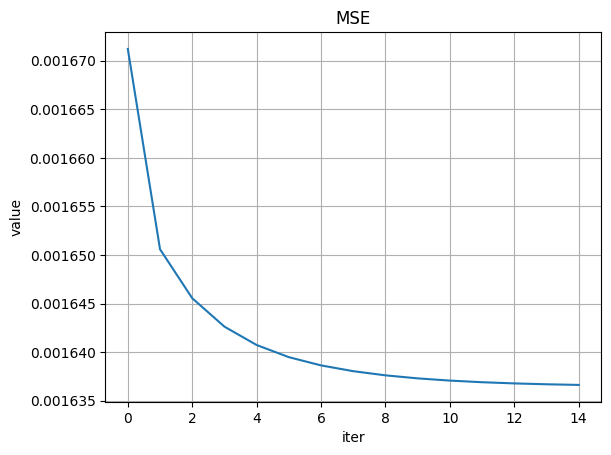

In [16]:
plt.plot(loss_values)
plt.title("MSE")
plt.xlabel("iter")
plt.ylabel("value")
plt.grid()

In [17]:
test_predictions = []

for user_index, item_index, true_rating in test_data:
    predicted_rating = np.dot(user_embeddings[user_index], item_embeddings[item_index])
    test_predictions.append((user_index, item_index, true_rating, predicted_rating))

# Example evaluation: Mean Squared Error (MSE)
mse = np.mean([(true - pred) ** 2 for (_, _, true, pred) in test_predictions])
print(f"Test MSE: {mse}")

Test MSE: 14.306747170062334


In [18]:
scores = np.dot(user_embeddings, item_embeddings.T)

Let's look at shapes of matrices:

In [19]:
scores.shape, user_embeddings.shape, item_embeddings.shape

((77398, 9214), (77398, 10), (9214, 10))

Let's calculate **MRR@k** (Mean Reciprocal Rank) for result evaluation. The formula for it:

$$ MRR = \frac{1}{N}\sum_{i=1}^{N} \frac{1}{{rank}_i}, $$

where $\text{rank}_i$ refers to the rank position of the first relevant document for the i-th user.

In [20]:
def mrr_at_k(predictions: np.ndarray, ground_truth: List[Tuple[int, int]], k: int =10):
    """Calculate Mean Reciprocal Rank at K (MRR@K)"""
    mrr = 0.0
    for user_index, true_item in ground_truth:
        top_k_items = predictions[user_index][:k]

        if true_item in top_k_items:
            rank = np.where(top_k_items == true_item)[0][0] + 1
            mrr += 1.0 / rank

    mrr /= len(ground_truth)
    return mrr

Also, we need method to calculate top-k recommendations:

In [21]:
def get_top_k_recommendations(user_embeddings: np.ndarray, item_embedding: np.ndarray, k: int = 10):
    """Get top-k recommendations for users"""
    scores = np.dot(user_embeddings, item_embeddings.T)
    top_k_items = np.argsort(scores, axis=1)[:, ::-1][:, :k]
    top_k_scores = np.take_along_axis(scores, top_k_items, axis=1)
    return top_k_items, top_k_scores

top_10_recommendations, top_10_scores = get_top_k_recommendations(user_embeddings, item_embeddings, k=10)

In [22]:
ground_truth = [(user_index, item_index) for user_index, item_index, _ in test_data]
mrr_10 = mrr_at_k(top_10_recommendations, ground_truth)
print(f"MRR@10 for self realization: {mrr_10}")

MRR@10 for self realization: 0.0007965220672759916


### 4. ALS from `implicit` library

Then, we use already implemented solution for ALS from `implicit` package and after that compare results with self-implemented alghorithm:

In [23]:
model = AlternatingLeastSquares(factors=10, regularization=0.1, iterations=15)
start = time.time()
model.fit(train_data, show_progress=True)
end = time.time()
print(f"Package implentations of ALS training took {end - start} sec")

/Users/naumov-vladis/miniconda3/envs/venv/lib/python3.9/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

Package implentations of ALS training took 3.0873749256134033 sec


In [24]:
user_factors = model.user_factors
item_factors = model.item_factors

In [25]:
test_predictions = []

for user_index, item_index, true_rating in test_data:
    predicted_rating = np.dot(user_factors[user_index], item_factors[item_index])
    test_predictions.append((user_index, item_index, true_rating, predicted_rating))

mse = np.mean([(true - pred) ** 2 for (_, _, true, pred) in test_predictions])
print(f"Test MSE: {mse}")

Test MSE: 14.304307842473168


In [26]:
def get_top_k_recommendations_implicit(model, train_data, k=10):
    """Get top-k recommendations for users with implicit library"""
    user_factors = model.user_factors
    item_factors = model.item_factors
    scores = np.dot(user_factors, item_factors.T)
    scores[train_data.nonzero()] = -np.inf  # Exclude already interacted items
    top_k_items = np.argsort(scores, axis=1)[:, -k:][:, ::-1]
    top_k_scores = np.take_along_axis(scores, top_k_items, axis=1)
    return top_k_items, top_k_scores

top_10_recommendations_implicit, top_10_scores_implicit = get_top_k_recommendations_implicit(model, train_data, k=10)

In [27]:
mrr_10_implicit= mrr_at_k(top_10_recommendations_implicit, ground_truth, k=10)
print(f"MRR@10 for `implicit` realization: {mrr_10_implicit}")

MRR@10 for `implicit` realization: 0.0008330026241390022


Finally, let's give a look at final film recommendations:

In [28]:
movies = pd.read_csv(
    "archive/movie_titles.csv", 
    names=["movie_id", "year", "movie_name"],
    encoding="utf-8", 
    sep=",", 
    on_bad_lines="skip",
)

Get first user and compare recommendations for him:

In [29]:
user_recoms = pd.DataFrame(
    list(zip(top_10_recommendations[0], top_10_scores[0])),
    columns=["movie_id", "pred_rating"]
)
user_recoms_implicit = pd.DataFrame(
    list(zip(top_10_recommendations_implicit[0], top_10_scores_implicit[0])),
    columns=["movie_id", "pred_rating"]
)

In [30]:
user_recoms.merge(movies, how="inner", on="movie_id")

,movie_id,pred_rating,year,movie_name
0,7529,3.444986e-31,1994.0,Sharpe 3: Sharpe's Company
1,1265,2.435352e-31,1971.0,Women in Cages
2,7825,1.678351e-31,2001.0,Prince Charming
3,7403,1.494581e-31,1995.0,An Awfully Big Adventure
4,8484,6.741076e-32,2004.0,Incubus: Alive at Red Rocks
5,6273,4.901211e-32,1979.0,Rock 'n' Roll High School
6,5710,4.744431e-32,2002.0,Possession
7,3600,1.282994e-32,1997.0,Head Above Water
8,1424,1.180401e-32,2000.0,Beautiful Joe
9,5187,1.121414e-32,1968.0,Funny Girl


In [31]:
user_recoms_implicit.merge(movies, how="inner", on="movie_id")

,movie_id,pred_rating,year,movie_name
0,2827,1.209205e-12,1988.0,Depeche Mode: 101
1,5951,1.034635e-12,2002.0,Twin Sisters
2,6677,7.778260e-13,1998.0,Desperate Measures
3,8484,6.801625e-13,2004.0,Incubus: Alive at Red Rocks
4,3949,6.403897e-13,1991.0,Terminator 2: Extreme Edition: Bonus Material
5,1218,6.339066e-13,1972.0,Frenzy
6,3600,6.166281e-13,1997.0,Head Above Water
7,7358,6.086505e-13,1998.0,The Brave Little Toaster Goes to Mars
8,4322,6.053517e-13,1998.0,City of Glass
9,8987,5.989767e-13,1999.0,Universal Soldier: The Return
